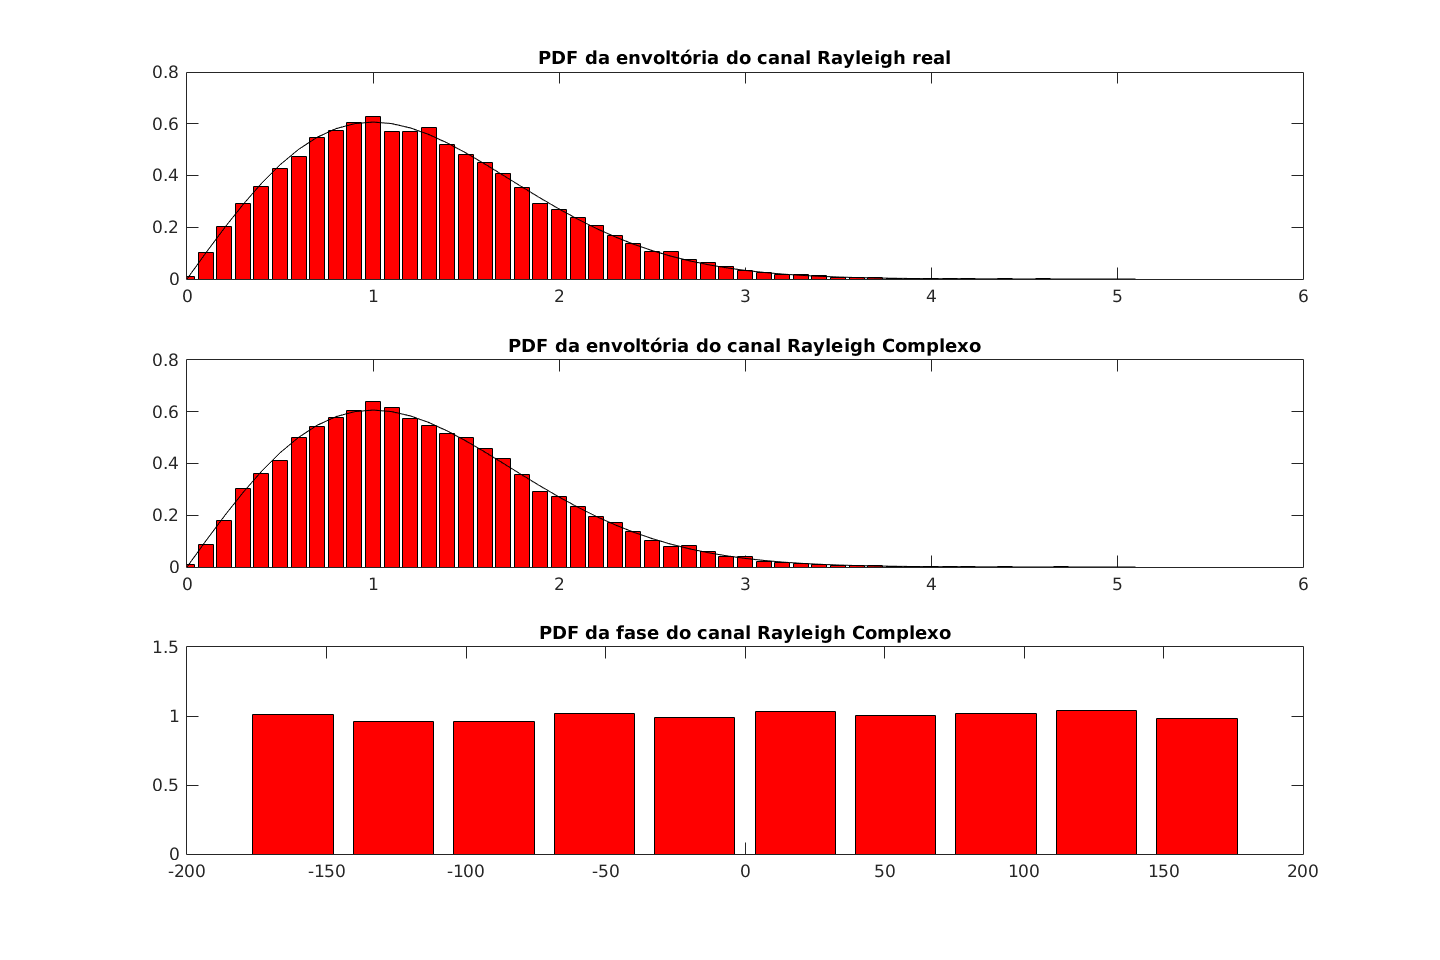

In [69]:
close all;clc;clear all;

% Parâmetros
N = 20000;
ts = 0.1;
x = [0:ts:5+ts];
sigma = 1;
u = rand(N,1);

% Canal Rayleigh real via método da inversão
rReal = sigma*sqrt(-2.*log(u));

% PDF Rayleigh teórico
pdfTeo = x/(sigma^2).*exp(-(x/sigma).^2/2);

% Canal Rayleigh complexo via VAs Gaussianas independentes
rComplexo = randn(N,1)+(1j).*randn(N,1);

% Gráficos
fig = figure;
fig.PaperUnits = 'inches';
fig.PaperPosition = [0 0 15 10];

subplot(3,1,1)

% Histograma do Canal real vs PDF teórica
[xh,temp] = hist(rReal,x);
temp = temp(1:length(temp));
bar(x,xh/(sum(xh)*ts), 'r');
hold on;

% PDF teórica
plot(x,pdfTeo,'k');
title('PDF da envoltória do canal Rayleigh real');
axis([0 6 0 0.8]);

% Envoltória do Canal complexo
subplot(3,1,2)

% Histograma da envoltória do canal complexo vs PDF teórica
[xh,temp] = hist(abs(rComplexo),x);
temp = temp(1:length(temp));
bar(x,xh/(sum(xh)*ts), 'r');
hold on;

% PDF teórica
plot(x,pdfTeo,'k');
title('PDF da envoltória do canal Rayleigh Complexo');
axis([0 6 0 0.8]);

% Histrograma da Fase do Canal complexo
% Gráficos
subplot(3,1,3);
[xhra, tempra]=hist(angle(rComplexo));
tempra = tempra(1:length(tempra));

bar(180/pi*tempra,xhra/(sum(xhra)*ts), 'r');
title('PDF da fase do canal Rayleigh Complexo');


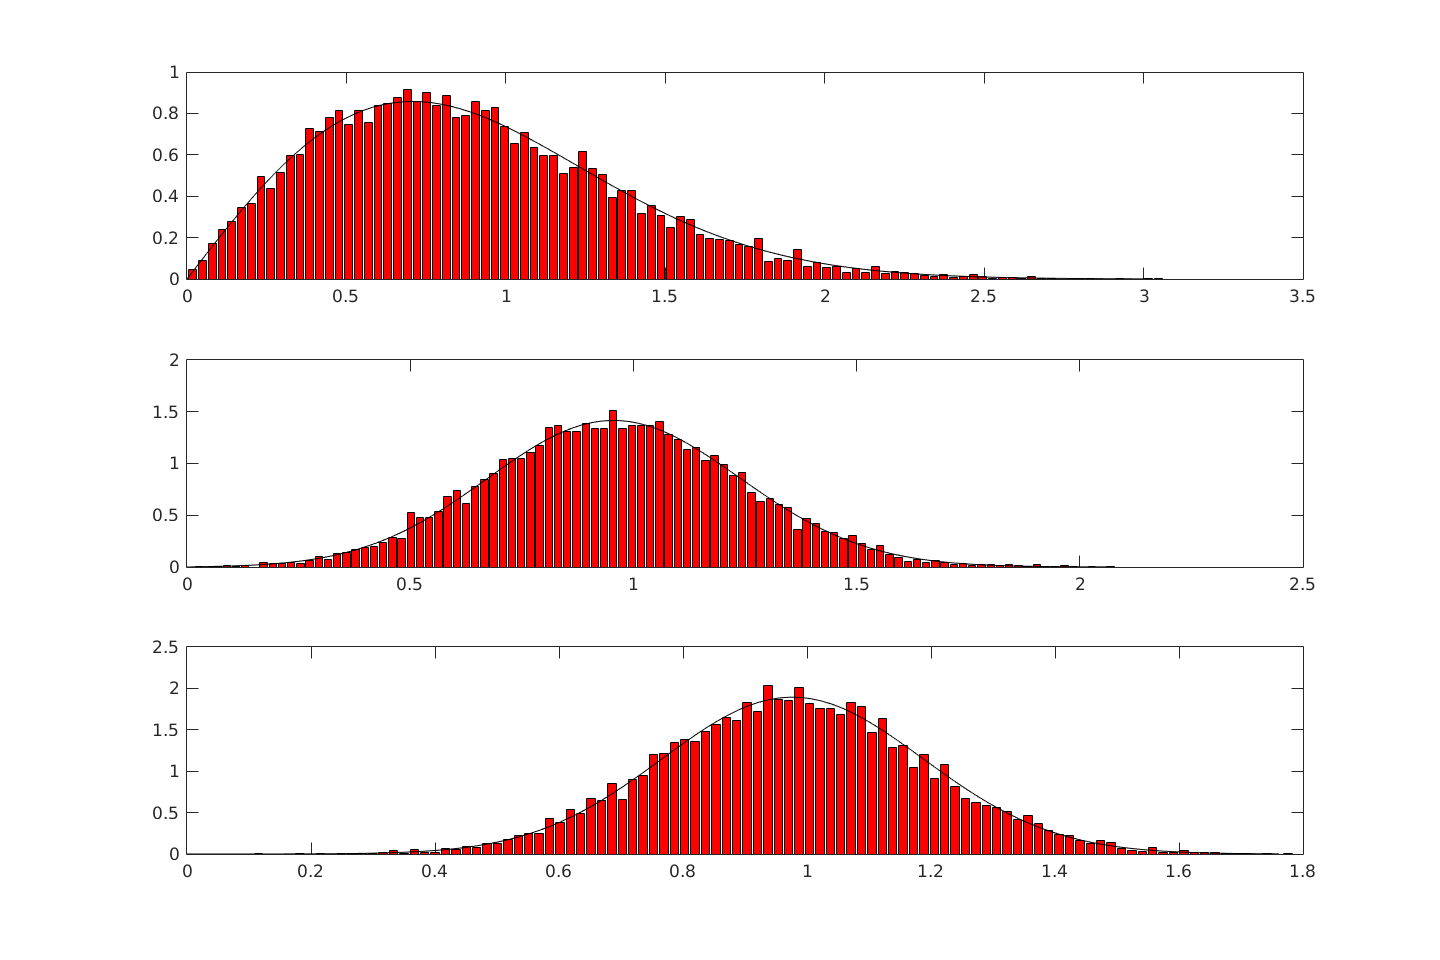

In [1]:
close all;clc;clear all;

% Parâmetros
N = 1e4;
vtK = [0,5,10];
totPower = 1;

% Gráficos
fig = figure;
fig.PaperUnits = 'inches';
fig.PaperPosition = [0 0 15 10];
    
% Loop nos valores de K
for ik = 1:length(vtK)
    K = vtK(ik);
    s = sqrt(K/(K+1).*totPower);                         % Parâmetro de não centralidade
    sigma = totPower/sqrt(2*(K+1));
    
    % Amostras do Canal Rice
    X = s + sigma.*randn(N,1);                           % LOS: VA Gaussina com média=s e sigma definido
    Y = 0 + sigma.*randn(N,1);                           % NLOS: VA Gaussina com média=0 e sigma definido
    Z = X + (1j)*Y;
    
    [val,bins] = hist(abs(Z), 100);                      % Histograma de Z
    
    %bins = bins(1:length(bins));                        % Ajuste do eixo
    
    % PDF Rice teórica
    binWidth = bins(2)-bins(1);
    r = [0:binWidth:max(bins)];

    subplot(length(vtK),1,ik)
    
    if K == 0
        rayleigh_pdf = r/(sigma.^2).*exp(-r.^2/(2*sigma.^2));
        plot(r,rayleigh_pdf,'g*');
    end
    
    fRice = 2*r*(K+1)./totPower.*exp(-r.^2*(K+1)/totPower-K).*besseli(0,2.*r.*sqrt(K*(K+1)/totPower));
    bar(bins,val/(binWidth*sum(val)), 'r');
    hold on;
    plot(r,fRice,'k');
    hold all;
end



[> In title (line 40)] 


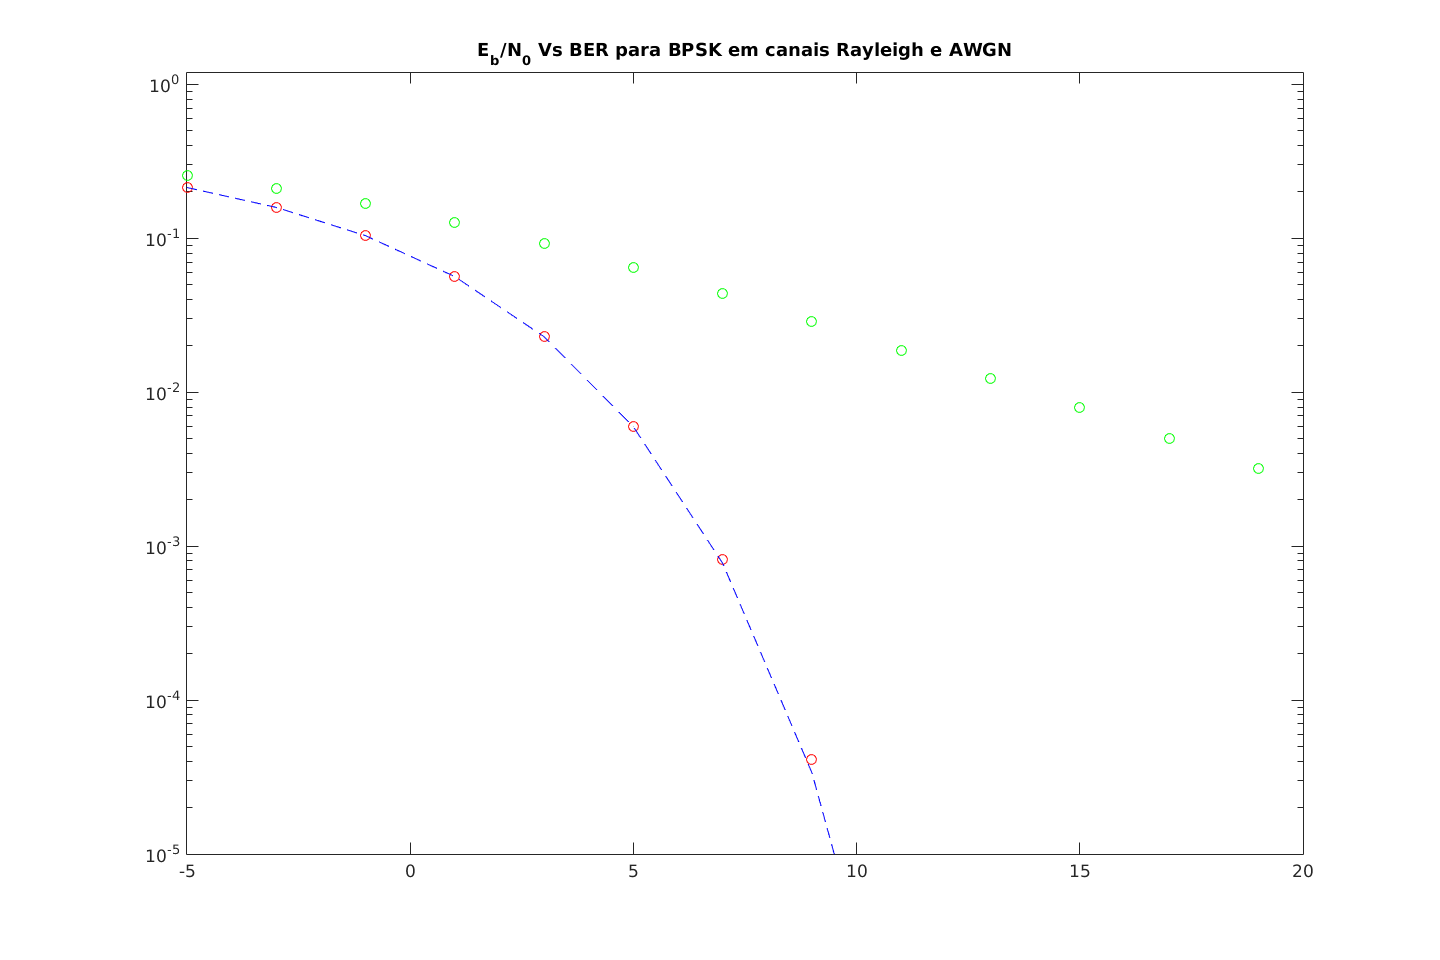

In [15]:
close all;clc;clear all;

% Parâmetros
N = 10^6;                         % Número de símbolos BPSK a serem transmitidos
EbN0dB = [-5:2:20];               % Valores EbN0 a simular

% Transmissor
d = rand(N,1) > 0.5;              % Dados binários 
x = 2*d -1;                       % Símbolos BPSK: 0 representado por -1 e 1 representado por 1

% Inicialização de vetores de BER simulada e teórica
BER_rayleigh_simulada = zeros(length(EbN0dB));
BER_awgn_simulada = zeros(length(EbN0dB));

% Loop de EbNo
for ik = 1:(length(EbN0dB))
    % Canal
    % Ruído AWGN complexo com média 0 e variância 1 (vetor base)
    noise = 1/sqrt(2).*(randn(N,1)+(1j)*randn(N,1));
    
    % Vetor de ruído com potência proporcional a EbNo corrente
    n = noise*10.^(-EbN0dB(ik)/20);  
    
    % Desvanecimento Rayleigh normalizado
    h = 1/sqrt(2)*(randn(N,1)+1j.*randn(N,1));
    
    % Sinal recebido para caso com somente ruído AWGN
    y_awgn = x + n; 
    
    % Sinal recebido para caso com desvanecimento Rayleigh e ruído AWGN
    y_rayleigh = h.*x + n;
    
    % Receptor coerente para o canal Rayleigh (supondo conhecimento de h no receptor)
    y_rayleigh_cap = y_rayleigh./h; % Equalizador
    
    % Os símbolos positivos recebidos são 1, os demais são 0 (lembrar da simbologia)
    r_rayleigh = real(y_rayleigh_cap)>0; 
    
    % Receptor para o canal somente AWGN
    r_awgn = real(y_awgn) > 0; 
    
    % Contador de erro para o caso com Rayleigh e AWGN
    BER_rayleigh_simulada(ik) = sum(bitxor(d,r_rayleigh));
    
    % Contador de erro para o caso com somente AWGN
    BER_awgn_simulada(ik) = sum(bitxor(d,r_awgn));
    % Fim do loop de EbN0
end
    
% Cálculo da BER para o caso com Rayleigh e AWGN
BER_rayleigh_simulada = BER_rayleigh_simulada/N; 

% Cálculo da BER para o caso com somente AWGN
BER_awgn_simulada = BER_awgn_simulada/N;

% Pe Teórica
EbN0=10.^(EbN0dB/10);            % Eb/N0 em escala linear

% Implementação direta da equação de Pe para o canal Rayleigh+AWGN
BER_rayleigh_teorica = 0.5*(1-sqrt(EbN0/sqrt(1+EbN0)));

% Implementação direta da equação de Pe para o canal somente AWGN
BER_awgn_teorica = qfunc(sqrt(2*EbN0));

% Gráficos
fig = figure;
fig.PaperUnits = 'inches';
fig.PaperPosition = [0 0 15 10];

% Rayleigh simulado
semilogy(EbN0dB,BER_rayleigh_simulada,'go');%,label='Rayleigh simulada');
hold on;

% AWGN simulado
semilogy(EbN0dB,BER_awgn_simulada,'ro');%,label='AWGN simulada');
hold on;

% Rayleigh teórico
semilogy(EbN0dB,BER_rayleigh_teorica,'k-');%,label='Rayleigh teórica');
hold on;

% AWGN teórico
semilogy(EbN0dB,BER_awgn_teorica,'b--');
title('E_b/N_0 Vs BER para BPSK em canais Rayleigh e AWGN');
axis([-5 20 10^(-5) 1.2]);
hold all;